# 一、从零实现线性回归

## 1.导入所需模块

In [2]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l

## 2.生成数据

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.8690,  0.4069]) 
label: tensor([-0.9130])


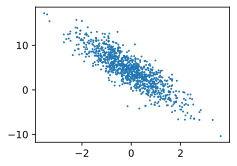

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

## 3.读取数据

In [9]:
# 生成小批量数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 获得每个batch_size的数据，但是最后一批数据可能不足一个batch_size
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8839, -0.3622],
        [-1.5467,  0.2205],
        [ 1.0639,  1.4730],
        [ 1.1534, -0.4701],
        [ 0.2519, -2.4692],
        [ 0.8566, -0.7594],
        [ 1.4990,  0.6654],
        [ 0.9998,  0.8835],
        [-0.6552, -1.3204],
        [-2.1764,  1.9030]]) 
 tensor([[ 7.2101],
        [ 0.3603],
        [ 1.3186],
        [ 8.0973],
        [13.1023],
        [ 8.4789],
        [ 4.9159],
        [ 3.1887],
        [ 7.3560],
        [-6.6122]])


## 4.定义初始化模型参数

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 5.定义模型

In [12]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 6.定义损失函数

In [13]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 7.定义优化算法

In [14]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    
    # 更新的时候不需要梯度计算
    with torch.no_grad():
        for param in params:
            
            # 损失函数中的均方误差没有除以均值，在更新参数时处理一样
            param -= lr * param.grad / batch_size
            
            # 将参数归零为下一次计算做准备，若未归零下次计算会与本次相关
            param.grad.zero_()

## 8.训练

In [15]:
lr = 0.03
num_epochs = 3
net = linreg   # 代码模块化思想，将方法赋给net，当需要改变方法时此处仅需要更改方法即可
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数（此处batch_size的最后一个可能不满足数量，具体问题还需具体对待）
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.022928
epoch 2, loss 0.000079
epoch 3, loss 0.000046


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0004, 0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


# 二、线性回归简洁实现

## 1.生成数据集

In [2]:
import numpy as np
import torch
from torch.utils import data   # 其中包含有一些数据处理的模块
from d2l import torch as d2l


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [3]:
help(d2l.synthetic_data)

Help on function synthetic_data in module d2l.torch:

synthetic_data(w, b, num_examples)
    Generate y = Xw + b + noise.



## 2.读取数据

In [4]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [7]:
next(iter(data_iter))

[tensor([[-0.3419,  1.1675],
         [-1.4059, -0.3622],
         [ 0.8339,  0.6266],
         [-0.5244,  0.9734],
         [-2.6857,  0.4953],
         [-0.5781, -0.9016],
         [-0.4468, -1.0988],
         [ 0.4764, -0.5007],
         [-0.3250,  2.1930],
         [ 1.2262, -0.3162]]),
 tensor([[-0.4471],
         [ 2.6254],
         [ 3.7330],
         [-0.1615],
         [-2.8442],
         [ 6.1328],
         [ 7.0350],
         [ 6.8425],
         [-3.9310],
         [ 7.7235]])]

## 3.定义模型

In [8]:
# `nn` 是神经网络的缩写
from torch import nn

# nn.Sequential是一个容器，模块将按照它们在构造函数中传递的顺序添加到它
net = nn.Sequential(nn.Linear(2, 1))

## 4.初始化模型参数

In [9]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 5.定义损失函数

In [10]:
loss = nn.MSELoss()

## 6.定义优化算法

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 7.训练

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()   # 这里pytorch已经做了sum
        trainer.step()   # 进行一次模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000213
epoch 2, loss 0.000101
epoch 3, loss 0.000101
